In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

import random
#from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.feature_selection import SelectFromModel

# Graph Neural Network (GNN)

Creating a Graph Neural Network (GNN) for regression tasks involves several steps, including defining the graph structure, selecting an appropriate GNN architecture, and setting up the training process. Below, I'll provide a basic example using PyTorch Geometric, a popular library for graph neural networks.




In [24]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00


In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Define a simple GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = torch.nn.Linear(hidden_channels, 1)  # Output is 1 for regression

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Two layers of GCN
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        # Global pooling (e.g., mean pooling)
        x = torch.mean(x, dim=0)

        # Linear layer for regression
        x = self.linear(x)

        return x

# Example graph data (you will need to replace this with your actual graph data)
# Assuming a graph with 3 nodes, each node has 5 features
num_node_features = 5
num_nodes = 3
x = torch.randn((num_nodes, num_node_features))  # Node features
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)  # Edges

# Creating a PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Instantiate the model
model = GCN(num_node_features=num_node_features, hidden_channels=16)

# Forward pass
output = model(data)
print(output)


tensor([-0.0136], grad_fn=<ViewBackward0>)


DGL(Deep Graph Library) backend pytorch tensorflow mxnet

In [18]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [19]:
!pip install dgl
import dgl
from dgl import DGLGraph

dgl.load_backend('pytorch')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 16.5 MB/s eta 0:00:00


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [20]:
from dgl.nn.pytorch import conv as dgl_conv

class GraphSAGEModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGEModel, self).__init__()
        self.layers = nn.ModuleList()

        # input layer
        self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type,
                                         feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type,
                                             feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type,
                                         feat_drop=dropout, activation=None))

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        return h

In [26]:
pip install dgl


  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


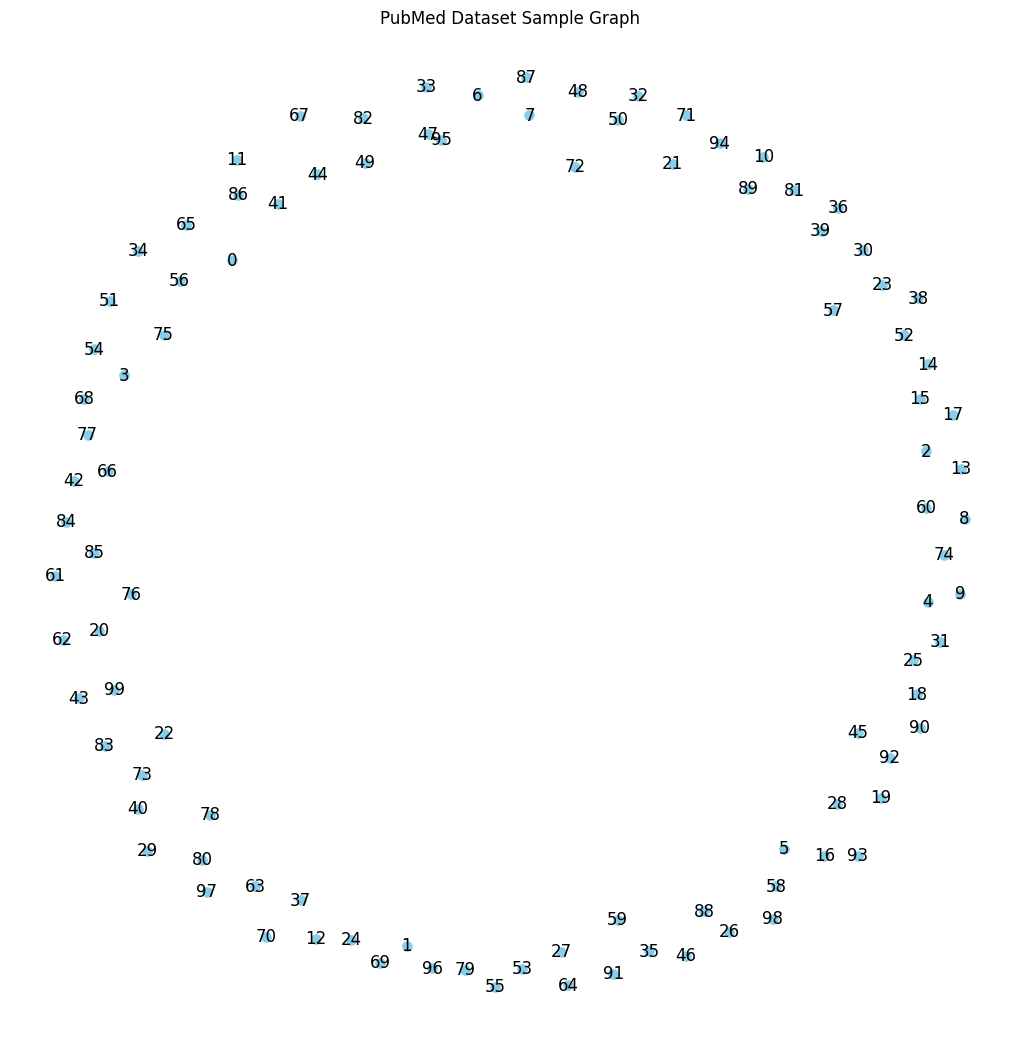

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
from dgl.data import citegrh
import dgl

def plot_graph(g, title):
    # Convert DGL graph to a NetworkX graph
    nx_g = g.to_networkx().to_undirected()

    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(nx_g, with_labels=True, node_size=50, node_color="skyblue", linewidths=0.5)
    plt.title(title)
    plt.show()

# Load the PubMed dataset
data = citegrh.load_pubmed()

# Get the graph
g = data[0]

# Plotting a small subgraph for visualization purposes
# Visualizing the entire graph can be very heavy and not informative due to its size
sub_g = dgl.node_subgraph(g, list(range(100)))  # Adjust the range for different subgraphs
plot_graph(sub_g, "PubMed Dataset Sample Graph")


In [30]:
from dgl.data import citegrh
#load the data
data = citegrh.load_pubmed()
g = data[0]


# Extract the graph
g = data[0]

# Features and labels are stored in the graph's ndata
features = g.ndata['feat']  # Node features
labels = g.ndata['label']  # Labels

# Number of classes and input feature dimension
n_classes = data.num_classes
in_feats = features.shape[1]

print("Features shape:", features.shape)
print("Number of classes:", n_classes)

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Features shape: torch.Size([19717, 500])
Number of classes: 3


GPT
In the code snippet you've provided, it appears that you are working with a graph dataset and trying to convert it into a DGL graph after removing self-loops using NetworkX. There are a few things to note and correct in your approach:

1. Import DGL: Ensure that you have DGL (Deep Graph Library) imported in your script.

2. Conversion to DGLGraph: The correct method to convert a NetworkX graph to a DGL graph is using dgl.from_networkx().

3. Readonly Graphs: In recent versions of DGL, the concept of readonly graphs has been deprecated. Modern DGL graphs are efficient and do not require setting them to readonly mode.

4. Removing Self-Loops: You can remove self-loops directly in DGL without using NetworkX.

The graph is first converted to a NetworkX graph
Self-loops are removed using NetworkX's remove_edges_from method.
The modified graph is then converted back to a DGL graph using dgl.from_networkx().
This process will ensure that the self-loops are removed and the graph is properly formatted for use in DGL. Remember to adjust the graph loading part (citegrh.load_pubmed()) according to your actual data source and requirements.

In [34]:
import networkx as nx
nx_g = g.to_networkx().to_undirected()

# Remove self-loops using NetworkX
nx_g.remove_edges_from(nx.selfloop_edges(nx_g))

# Convert back to DGL graph
dgl_g = dgl.from_networkx(nx_g)

# DGL handles graphs efficiently, so no need to set readonly
print("Number of nodes:", dgl_g.number_of_nodes())
print("Number of edges:", dgl_g.number_of_edges())

Number of nodes: 19717
Number of edges: 88648


# Semi-supervised node classification

In [35]:
n_hidden = 64
n_layers = 2
dropout = 0.5
aggregator_type = 'gcn'

gconv_model = GraphSAGEModel(in_feats,
                             n_hidden,
                             n_classes,
                             n_layers,
                             F.relu,
                             dropout,
                             aggregator_type)

In [42]:
class NodeClassification(nn.Module):
    def __init__(self, gconv_model, n_hidden, n_classes):
        super(NodeClassification, self).__init__()
        self.gconv_model = gconv_model
        self.loss_fcn = torch.nn.CrossEntropyLoss()

    def forward(self, g, features, train_mask):
        logits = self.gconv_model(g, features)
        return self.loss_fcn(logits[train_mask], labels[train_mask])




In [44]:
def NCEvaluate(model, g, features, labels, test_mask):
    model.eval()
    with torch.no_grad():
        logits = model.gconv_model(g, features)
        logits = logits[test_mask]                          #Test set에서만 accuracy 계산
        test_labels = labels[test_mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == test_labels)
        return correct.item() * 1.0 / len(test_labels)

In [49]:
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

# Convert to boolean tensors (if they are not already)
train_mask = torch.BoolTensor(train_mask)
val_mask = torch.BoolTensor(val_mask)
test_mask = torch.BoolTensor(test_mask)

# Number of classes
n_classes = data.num_classes

# Print data statistics
print(f"----Data statistics------\n"
      f"#Classes: {n_classes}\n"
      f"#Train samples: {train_mask.sum().item()}\n"
      f"#Val samples: {val_mask.sum().item()}\n"
      f"#Test samples: {test_mask.sum().item()}")



----Data statistics------
#Classes: 3
#Train samples: 60
#Val samples: 500
#Test samples: 1000


In [50]:
model = NodeClassification(gconv_model, n_hidden, n_classes)

# 하이퍼파라미터
weight_decay = 5e-4
n_epochs = 150
lr = 1e-3

# 옵티마이저
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    model.train()

    loss = model(g, features, train_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = NCEvaluate(model, g, features, labels, val_mask)
    print("Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f}"
          .format(epoch, loss.item(), acc))

acc = NCEvaluate(model, g, features, labels, test_mask)
print("\nTest Accuracy {:.4f}".format(acc))

Epoch 00000 | Loss 1.0979 | Accuracy 0.4320
Epoch 00001 | Loss 1.0969 | Accuracy 0.4360
Epoch 00002 | Loss 1.0949 | Accuracy 0.4500
Epoch 00003 | Loss 1.0924 | Accuracy 0.4740
Epoch 00004 | Loss 1.0935 | Accuracy 0.4820
Epoch 00005 | Loss 1.0902 | Accuracy 0.5380
Epoch 00006 | Loss 1.0876 | Accuracy 0.5820
Epoch 00007 | Loss 1.0891 | Accuracy 0.6080
Epoch 00008 | Loss 1.0835 | Accuracy 0.6480
Epoch 00009 | Loss 1.0837 | Accuracy 0.6660
Epoch 00010 | Loss 1.0816 | Accuracy 0.6780
Epoch 00011 | Loss 1.0791 | Accuracy 0.6840
Epoch 00012 | Loss 1.0761 | Accuracy 0.6880
Epoch 00013 | Loss 1.0729 | Accuracy 0.6940
Epoch 00014 | Loss 1.0741 | Accuracy 0.6980
Epoch 00015 | Loss 1.0681 | Accuracy 0.7000
Epoch 00016 | Loss 1.0670 | Accuracy 0.7020
Epoch 00017 | Loss 1.0624 | Accuracy 0.7120
Epoch 00018 | Loss 1.0615 | Accuracy 0.7160
Epoch 00019 | Loss 1.0549 | Accuracy 0.7120
Epoch 00020 | Loss 1.0482 | Accuracy 0.7080
Epoch 00021 | Loss 1.0476 | Accuracy 0.7120
Epoch 00022 | Loss 1.0417 | Accu

Epoch 00000 | Loss 0.1155 | Train Acc 0.9833 | Val Acc 0.7900
Epoch 00001 | Loss 0.1230 | Train Acc 0.9833 | Val Acc 0.7820
Epoch 00002 | Loss 0.1697 | Train Acc 0.9833 | Val Acc 0.7820
Epoch 00003 | Loss 0.1495 | Train Acc 0.9833 | Val Acc 0.7820
Epoch 00004 | Loss 0.1286 | Train Acc 1.0000 | Val Acc 0.7780
Epoch 00005 | Loss 0.1459 | Train Acc 1.0000 | Val Acc 0.7800
Epoch 00006 | Loss 0.1251 | Train Acc 1.0000 | Val Acc 0.7820
Epoch 00007 | Loss 0.1284 | Train Acc 1.0000 | Val Acc 0.7840
Epoch 00008 | Loss 0.1410 | Train Acc 1.0000 | Val Acc 0.7800
Epoch 00009 | Loss 0.1326 | Train Acc 1.0000 | Val Acc 0.7800
Epoch 00010 | Loss 0.1468 | Train Acc 1.0000 | Val Acc 0.7820
Epoch 00011 | Loss 0.1185 | Train Acc 1.0000 | Val Acc 0.7860
Epoch 00012 | Loss 0.1139 | Train Acc 1.0000 | Val Acc 0.7880
Epoch 00013 | Loss 0.1051 | Train Acc 1.0000 | Val Acc 0.7860
Epoch 00014 | Loss 0.1121 | Train Acc 1.0000 | Val Acc 0.7840
Epoch 00015 | Loss 0.0996 | Train Acc 1.0000 | Val Acc 0.7800
Epoch 00

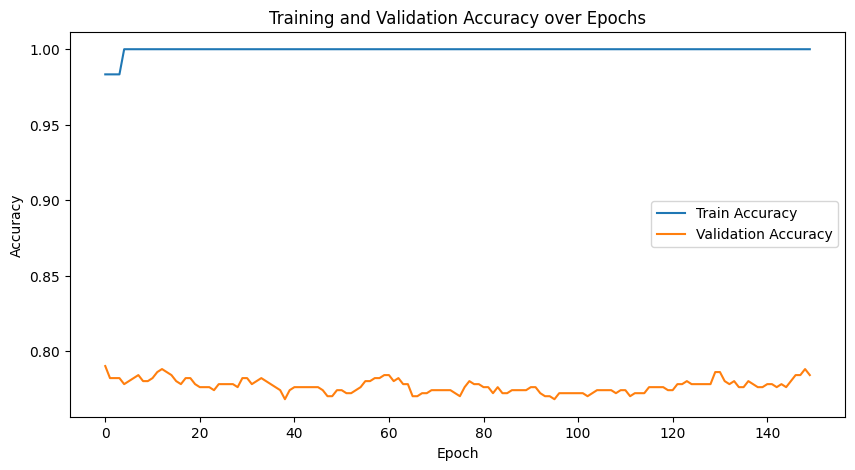

In [51]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming your NodeClassification, NCEvaluate, and other setup code here

model = NodeClassification(gconv_model, n_hidden, n_classes)

# Hyperparameters
weight_decay = 5e-4
n_epochs = 150
lr = 1e-3

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# For storing accuracies
train_accs = []
val_accs = []

for epoch in range(n_epochs):
    model.train()

    loss = model(g, features, train_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate on training set and validation set
    train_acc = NCEvaluate(model, g, features, labels, train_mask)
    val_acc = NCEvaluate(model, g, features, labels, val_mask)

    # Store accuracies
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f} | Val Acc {:.4f}"
          .format(epoch, loss.item(), train_acc, val_acc))

# Final Test Accuracy
test_acc = NCEvaluate(model, g, features, labels, test_mask)
print("\nTest Accuracy {:.4f}".format(test_acc))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()


## Hyper-Tunning

Improving the test accuracy of a Graph Neural Network (GNN) model, such as the one you've implemented for node classification, involves several strategies. Here are some approaches you can consider:

1. **Hyperparameter Tuning**:
   - **Learning Rate**: Experiment with different learning rates. Sometimes a smaller learning rate can lead to better convergence.
   - **Number of Epochs**: Increase the number of training epochs, but be mindful of overfitting.
   - **Hidden Layers and Units**: Adjust the number and size of hidden layers in your GNN. Sometimes increasing the model complexity can help, provided you have enough data.
   - **Dropout Rate**: Experiment with different dropout rates to prevent overfitting.

2. **Feature Engineering**:
   - **Node Features**: Investigate if you can include more informative or high-quality features for the nodes.
   - **Feature Normalization**: Standardizing or normalizing features can sometimes improve performance.

3. **Model Architecture**:
   - **Different Aggregators**: If you're using GraphSAGE, try different aggregator functions (mean, LSTM, pooling).
   - **Advanced GNN Layers**: Experiment with more advanced GNN layers or architectures, like GAT (Graph Attention Networks) or GCN (Graph Convolutional Networks).

4. **Regularization Techniques**:
   - **Weight Decay**: Adjust the weight decay parameter to regularize the training process.
   - **Early Stopping**: Implement early stopping to prevent overfitting.

5. **Data Augmentation**:
   - **Graph Perturbation**: Slightly modify the graph structure (e.g., adding/dropping edges) as a form of data augmentation.
   - **Node Feature Perturbation**: Add noise or variations to node features during training.

6. **Training Procedure**:
   - **Batch Training**: If not already doing so, use mini-batch training which can sometimes improve the generalization of the model.
   - **Learning Rate Scheduling**: Implement learning rate schedulers that adjust the learning rate during training.

7. **Evaluation Metrics and Loss Function**:
   - Ensure that you're using the most appropriate evaluation metrics and loss functions for your specific problem.

8. **Computational Resources**:
   - More computational resources allow for experimenting with larger models and more extensive hyperparameter tuning.

9. **Ensemble Methods**:
   - Combine predictions from multiple models (ensembles) to improve accuracy.

10. **Literature and Case Studies**:
    - Review current literature for similar tasks and case studies to find insights and techniques that have been effective in similar scenarios.

Keep in mind visulisation and have other metrics rather than accuracy like F1 score would give better grasp on underfitting and overfitting issue.

Training with lr: 0.01, weight_decay: 0.0005
Epoch 00000 | Loss 0.0267 | Train Acc 0.8833 | Val Acc 0.6540
Epoch 00001 | Loss 0.3376 | Train Acc 1.0000 | Val Acc 0.7760
Epoch 00002 | Loss 0.0254 | Train Acc 0.9833 | Val Acc 0.7720
Epoch 00003 | Loss 0.0889 | Train Acc 0.9667 | Val Acc 0.7220
Epoch 00004 | Loss 0.2638 | Train Acc 0.9833 | Val Acc 0.7620
Epoch 00005 | Loss 0.1029 | Train Acc 0.9833 | Val Acc 0.7840
Epoch 00006 | Loss 0.0787 | Train Acc 1.0000 | Val Acc 0.7840
Epoch 00007 | Loss 0.0485 | Train Acc 1.0000 | Val Acc 0.7780
Epoch 00008 | Loss 0.0467 | Train Acc 1.0000 | Val Acc 0.7640
Epoch 00009 | Loss 0.0612 | Train Acc 0.9833 | Val Acc 0.7420
Epoch 00010 | Loss 0.0681 | Train Acc 0.9833 | Val Acc 0.7380
Epoch 00011 | Loss 0.0904 | Train Acc 1.0000 | Val Acc 0.7500
Epoch 00012 | Loss 0.0837 | Train Acc 1.0000 | Val Acc 0.7700
Epoch 00013 | Loss 0.0547 | Train Acc 1.0000 | Val Acc 0.7720
Epoch 00014 | Loss 0.0216 | Train Acc 1.0000 | Val Acc 0.7780
Epoch 00015 | Loss 0.0186

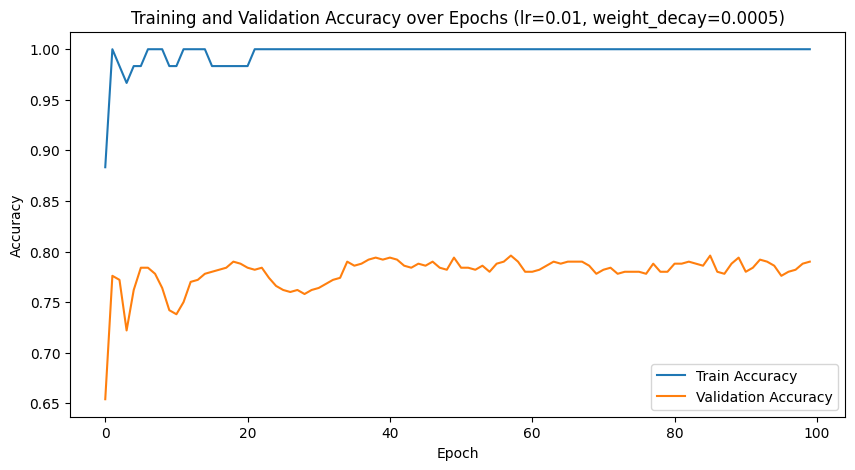

Training with lr: 0.01, weight_decay: 0.005
Epoch 00000 | Loss 0.0141 | Train Acc 0.9833 | Val Acc 0.6960
Epoch 00001 | Loss 0.1722 | Train Acc 1.0000 | Val Acc 0.7800
Epoch 00002 | Loss 0.0331 | Train Acc 0.9167 | Val Acc 0.5600
Epoch 00003 | Loss 0.3109 | Train Acc 0.9667 | Val Acc 0.6740
Epoch 00004 | Loss 0.1616 | Train Acc 1.0000 | Val Acc 0.7980
Epoch 00005 | Loss 0.0741 | Train Acc 0.9833 | Val Acc 0.7420
Epoch 00006 | Loss 0.1085 | Train Acc 0.9500 | Val Acc 0.7000
Epoch 00007 | Loss 0.2275 | Train Acc 0.9667 | Val Acc 0.7280
Epoch 00008 | Loss 0.1549 | Train Acc 0.9833 | Val Acc 0.7860
Epoch 00009 | Loss 0.1365 | Train Acc 1.0000 | Val Acc 0.7960
Epoch 00010 | Loss 0.0936 | Train Acc 1.0000 | Val Acc 0.7300
Epoch 00011 | Loss 0.1391 | Train Acc 0.9833 | Val Acc 0.7020
Epoch 00012 | Loss 0.2355 | Train Acc 0.9833 | Val Acc 0.7420
Epoch 00013 | Loss 0.1793 | Train Acc 1.0000 | Val Acc 0.7700
Epoch 00014 | Loss 0.1161 | Train Acc 1.0000 | Val Acc 0.7860
Epoch 00015 | Loss 0.1033 

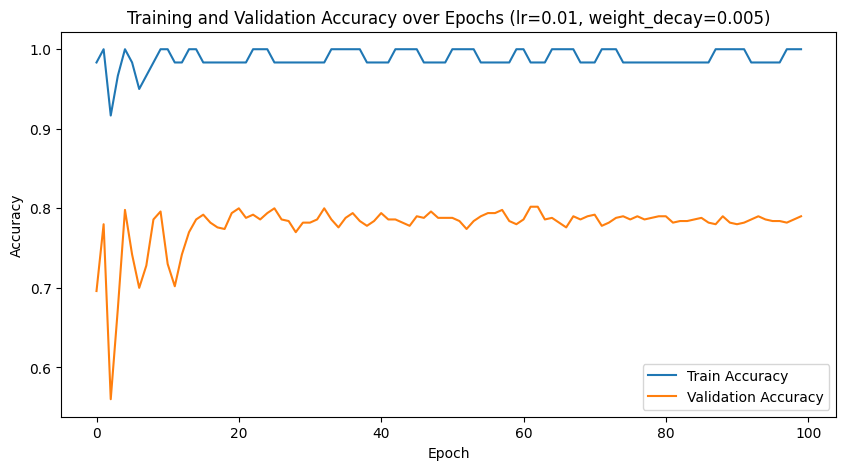

Training with lr: 0.01, weight_decay: 0.05
Epoch 00000 | Loss 0.1396 | Train Acc 0.8333 | Val Acc 0.7000
Epoch 00001 | Loss 0.4060 | Train Acc 0.9833 | Val Acc 0.7640
Epoch 00002 | Loss 0.3922 | Train Acc 0.9167 | Val Acc 0.6800
Epoch 00003 | Loss 0.4753 | Train Acc 0.9167 | Val Acc 0.6580
Epoch 00004 | Loss 0.5797 | Train Acc 0.9500 | Val Acc 0.7940
Epoch 00005 | Loss 0.5969 | Train Acc 0.9167 | Val Acc 0.7780
Epoch 00006 | Loss 0.6229 | Train Acc 0.8167 | Val Acc 0.7360
Epoch 00007 | Loss 0.7852 | Train Acc 0.8333 | Val Acc 0.7380
Epoch 00008 | Loss 0.8020 | Train Acc 0.8667 | Val Acc 0.7620
Epoch 00009 | Loss 0.8442 | Train Acc 0.8833 | Val Acc 0.7660
Epoch 00010 | Loss 0.8171 | Train Acc 0.8333 | Val Acc 0.7100
Epoch 00011 | Loss 0.8727 | Train Acc 0.6667 | Val Acc 0.5500
Epoch 00012 | Loss 0.8830 | Train Acc 0.6833 | Val Acc 0.5600
Epoch 00013 | Loss 0.9306 | Train Acc 0.7500 | Val Acc 0.6400
Epoch 00014 | Loss 0.9472 | Train Acc 0.8333 | Val Acc 0.7420
Epoch 00015 | Loss 0.9545 |

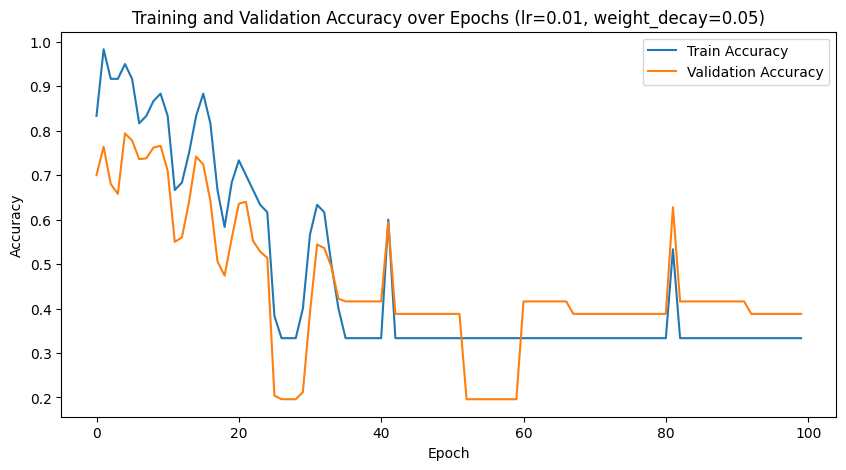

Training with lr: 0.001, weight_decay: 0.0005
Epoch 00000 | Loss 1.0982 | Train Acc 0.3333 | Val Acc 0.4160
Epoch 00001 | Loss 1.0990 | Train Acc 0.3333 | Val Acc 0.4160
Epoch 00002 | Loss 1.0979 | Train Acc 0.3333 | Val Acc 0.4160
Epoch 00003 | Loss 1.0983 | Train Acc 0.3333 | Val Acc 0.4160
Epoch 00004 | Loss 1.0991 | Train Acc 0.3333 | Val Acc 0.4160
Epoch 00005 | Loss 1.0986 | Train Acc 0.3333 | Val Acc 0.3880
Epoch 00006 | Loss 1.0983 | Train Acc 0.3333 | Val Acc 0.3880
Epoch 00007 | Loss 1.0983 | Train Acc 0.3333 | Val Acc 0.3880
Epoch 00008 | Loss 1.0978 | Train Acc 0.3333 | Val Acc 0.3880
Epoch 00009 | Loss 1.0998 | Train Acc 0.4667 | Val Acc 0.4620
Epoch 00010 | Loss 1.0980 | Train Acc 0.7167 | Val Acc 0.5720
Epoch 00011 | Loss 1.0982 | Train Acc 0.4667 | Val Acc 0.2580
Epoch 00012 | Loss 1.0988 | Train Acc 0.5667 | Val Acc 0.3720
Epoch 00013 | Loss 1.0977 | Train Acc 0.5333 | Val Acc 0.3760
Epoch 00014 | Loss 1.0986 | Train Acc 0.5333 | Val Acc 0.3240
Epoch 00015 | Loss 1.098

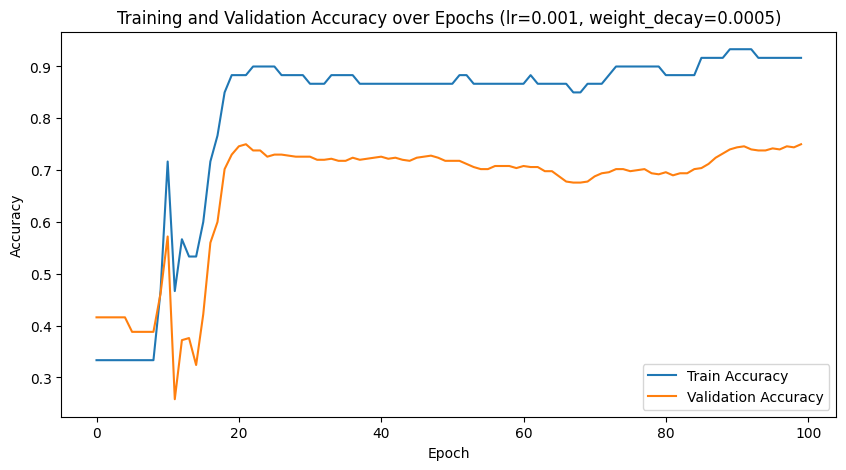

Training with lr: 0.001, weight_decay: 0.005
Epoch 00000 | Loss 0.5156 | Train Acc 0.9167 | Val Acc 0.7480
Epoch 00001 | Loss 0.5165 | Train Acc 0.9167 | Val Acc 0.7540
Epoch 00002 | Loss 0.5430 | Train Acc 0.9167 | Val Acc 0.7520
Epoch 00003 | Loss 0.5132 | Train Acc 0.9000 | Val Acc 0.7500
Epoch 00004 | Loss 0.5147 | Train Acc 0.9000 | Val Acc 0.7500
Epoch 00005 | Loss 0.5080 | Train Acc 0.9000 | Val Acc 0.7500
Epoch 00006 | Loss 0.5068 | Train Acc 0.9000 | Val Acc 0.7500
Epoch 00007 | Loss 0.5142 | Train Acc 0.9000 | Val Acc 0.7500
Epoch 00008 | Loss 0.5263 | Train Acc 0.9167 | Val Acc 0.7480
Epoch 00009 | Loss 0.4984 | Train Acc 0.9167 | Val Acc 0.7520
Epoch 00010 | Loss 0.5128 | Train Acc 0.9167 | Val Acc 0.7540
Epoch 00011 | Loss 0.5046 | Train Acc 0.9167 | Val Acc 0.7520
Epoch 00012 | Loss 0.5451 | Train Acc 0.9167 | Val Acc 0.7560
Epoch 00013 | Loss 0.5116 | Train Acc 0.9167 | Val Acc 0.7560
Epoch 00014 | Loss 0.5082 | Train Acc 0.9167 | Val Acc 0.7560
Epoch 00015 | Loss 0.5244

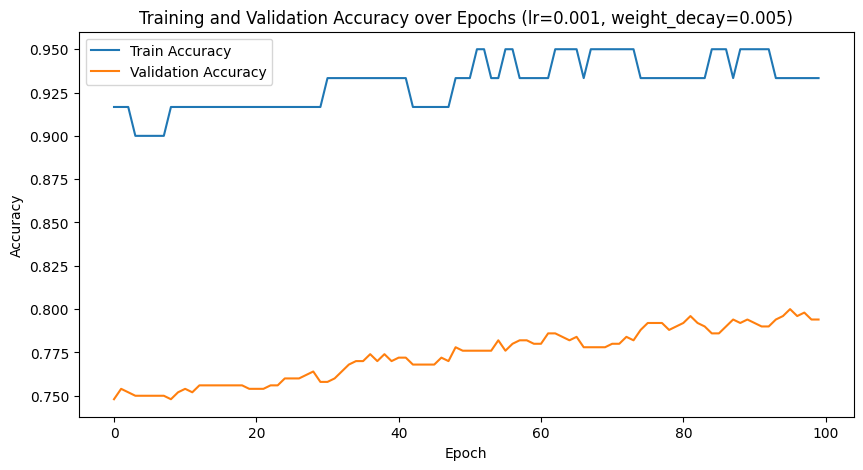

Training with lr: 0.001, weight_decay: 0.05
Epoch 00000 | Loss 0.3880 | Train Acc 0.9333 | Val Acc 0.7860
Epoch 00001 | Loss 0.3917 | Train Acc 0.9500 | Val Acc 0.7840
Epoch 00002 | Loss 0.3785 | Train Acc 0.9500 | Val Acc 0.7920
Epoch 00003 | Loss 0.3983 | Train Acc 0.9333 | Val Acc 0.7960
Epoch 00004 | Loss 0.4053 | Train Acc 0.9333 | Val Acc 0.7960
Epoch 00005 | Loss 0.4121 | Train Acc 0.9333 | Val Acc 0.7960
Epoch 00006 | Loss 0.4663 | Train Acc 0.9333 | Val Acc 0.7960
Epoch 00007 | Loss 0.4428 | Train Acc 0.9333 | Val Acc 0.7960
Epoch 00008 | Loss 0.4214 | Train Acc 0.9333 | Val Acc 0.7960
Epoch 00009 | Loss 0.4389 | Train Acc 0.9333 | Val Acc 0.7980
Epoch 00010 | Loss 0.4906 | Train Acc 0.9333 | Val Acc 0.7940
Epoch 00011 | Loss 0.4772 | Train Acc 0.9333 | Val Acc 0.7980
Epoch 00012 | Loss 0.5106 | Train Acc 0.9333 | Val Acc 0.7980
Epoch 00013 | Loss 0.5106 | Train Acc 0.9333 | Val Acc 0.8060
Epoch 00014 | Loss 0.5152 | Train Acc 0.9333 | Val Acc 0.8020
Epoch 00015 | Loss 0.4922 

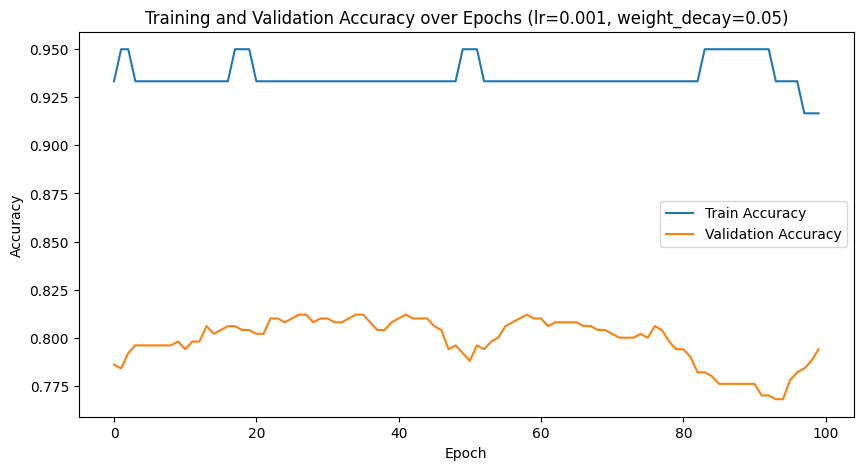

Training with lr: 0.0001, weight_decay: 0.0005
Epoch 00000 | Loss 0.9429 | Train Acc 0.9167 | Val Acc 0.7920
Epoch 00001 | Loss 0.9405 | Train Acc 0.9167 | Val Acc 0.7900
Epoch 00002 | Loss 0.9596 | Train Acc 0.9167 | Val Acc 0.7860
Epoch 00003 | Loss 0.9562 | Train Acc 0.9167 | Val Acc 0.7880
Epoch 00004 | Loss 0.9326 | Train Acc 0.9167 | Val Acc 0.7880
Epoch 00005 | Loss 0.9541 | Train Acc 0.9167 | Val Acc 0.7860
Epoch 00006 | Loss 0.9391 | Train Acc 0.9167 | Val Acc 0.7820
Epoch 00007 | Loss 0.9466 | Train Acc 0.9167 | Val Acc 0.7840
Epoch 00008 | Loss 0.9409 | Train Acc 0.9167 | Val Acc 0.7820
Epoch 00009 | Loss 0.9450 | Train Acc 0.9167 | Val Acc 0.7780
Epoch 00010 | Loss 0.9349 | Train Acc 0.9333 | Val Acc 0.7780
Epoch 00011 | Loss 0.9316 | Train Acc 0.9333 | Val Acc 0.7760
Epoch 00012 | Loss 0.9536 | Train Acc 0.9333 | Val Acc 0.7740
Epoch 00013 | Loss 0.9471 | Train Acc 0.9333 | Val Acc 0.7740
Epoch 00014 | Loss 0.9487 | Train Acc 0.9333 | Val Acc 0.7700
Epoch 00015 | Loss 0.92

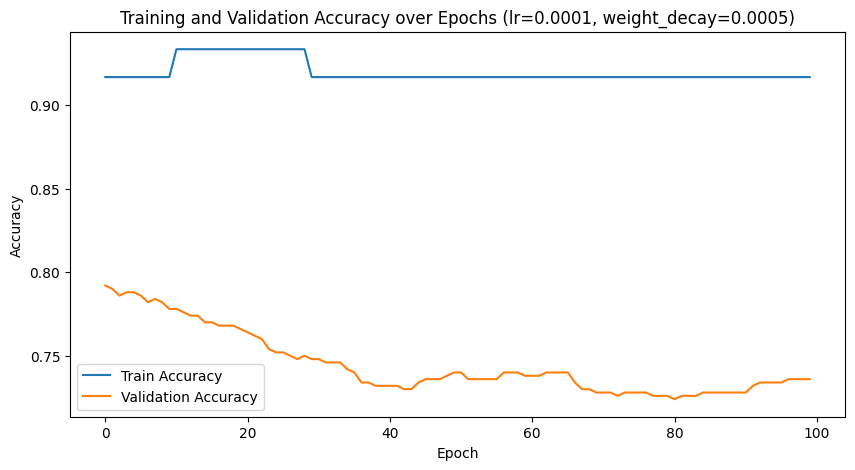

Training with lr: 0.0001, weight_decay: 0.005
Epoch 00000 | Loss 0.8667 | Train Acc 0.9167 | Val Acc 0.7360
Epoch 00001 | Loss 0.8593 | Train Acc 0.9167 | Val Acc 0.7340
Epoch 00002 | Loss 0.8527 | Train Acc 0.9167 | Val Acc 0.7340
Epoch 00003 | Loss 0.8547 | Train Acc 0.9167 | Val Acc 0.7340
Epoch 00004 | Loss 0.8761 | Train Acc 0.9167 | Val Acc 0.7320
Epoch 00005 | Loss 0.8483 | Train Acc 0.9167 | Val Acc 0.7320
Epoch 00006 | Loss 0.8784 | Train Acc 0.9167 | Val Acc 0.7320
Epoch 00007 | Loss 0.8604 | Train Acc 0.9167 | Val Acc 0.7320
Epoch 00008 | Loss 0.8676 | Train Acc 0.9167 | Val Acc 0.7340
Epoch 00009 | Loss 0.8580 | Train Acc 0.9167 | Val Acc 0.7320
Epoch 00010 | Loss 0.8614 | Train Acc 0.9167 | Val Acc 0.7340
Epoch 00011 | Loss 0.8611 | Train Acc 0.9167 | Val Acc 0.7360
Epoch 00012 | Loss 0.8556 | Train Acc 0.9167 | Val Acc 0.7380
Epoch 00013 | Loss 0.8623 | Train Acc 0.9167 | Val Acc 0.7380
Epoch 00014 | Loss 0.8419 | Train Acc 0.9167 | Val Acc 0.7400
Epoch 00015 | Loss 0.865

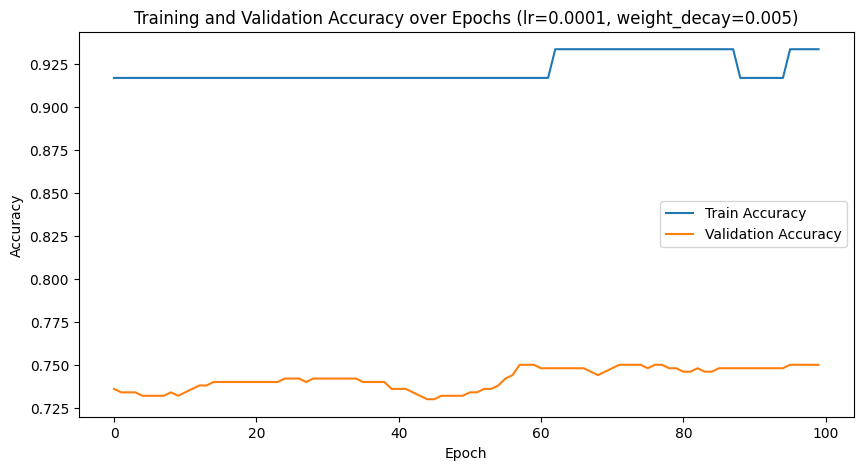

Training with lr: 0.0001, weight_decay: 0.05
Epoch 00000 | Loss 0.8013 | Train Acc 0.9333 | Val Acc 0.7500
Epoch 00001 | Loss 0.7859 | Train Acc 0.9333 | Val Acc 0.7500
Epoch 00002 | Loss 0.7735 | Train Acc 0.9333 | Val Acc 0.7500
Epoch 00003 | Loss 0.7843 | Train Acc 0.9333 | Val Acc 0.7500
Epoch 00004 | Loss 0.7912 | Train Acc 0.9333 | Val Acc 0.7500
Epoch 00005 | Loss 0.7838 | Train Acc 0.9333 | Val Acc 0.7520
Epoch 00006 | Loss 0.8072 | Train Acc 0.9333 | Val Acc 0.7500
Epoch 00007 | Loss 0.7774 | Train Acc 0.9333 | Val Acc 0.7520
Epoch 00008 | Loss 0.7881 | Train Acc 0.9333 | Val Acc 0.7540
Epoch 00009 | Loss 0.8084 | Train Acc 0.9333 | Val Acc 0.7540
Epoch 00010 | Loss 0.8081 | Train Acc 0.9333 | Val Acc 0.7560
Epoch 00011 | Loss 0.7843 | Train Acc 0.9333 | Val Acc 0.7560
Epoch 00012 | Loss 0.8017 | Train Acc 0.9333 | Val Acc 0.7560
Epoch 00013 | Loss 0.8052 | Train Acc 0.9333 | Val Acc 0.7540
Epoch 00014 | Loss 0.8131 | Train Acc 0.9333 | Val Acc 0.7540
Epoch 00015 | Loss 0.7696

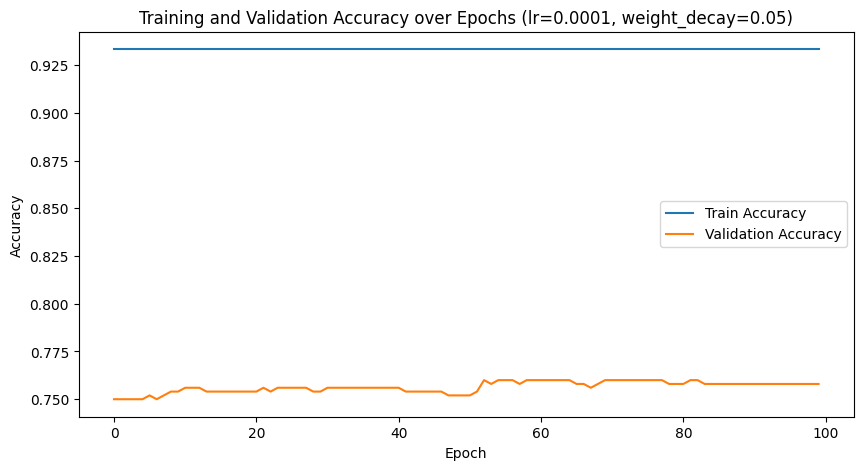

Best Hyperparameters: lr=0.001, weight_decay=0.005

Test Accuracy with Best Model: 0.7030


In [71]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming your NodeClassification, NCEvaluate, and other setup code here

# Define the range of hyperparameters you want to test
learning_rates = [1e-2, 1e-3, 1e-4]
weight_decays = [5e-4, 5e-3, 5e-2]
n_epochs = 100

best_val_acc = 0
best_hyperparams = {}

for lr in learning_rates:
    for weight_decay in weight_decays:
        print(f"Training with lr: {lr}, weight_decay: {weight_decay}")

        # Initialize the model
        model = NodeClassification(gconv_model, n_hidden, n_classes)

        # Optimizer with current hyperparameters
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Lists to store accuracies for plotting
        train_accs = []
        val_accs = []

        for epoch in range(n_epochs):
            model.train()
            loss = model(g, features, train_mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Evaluate on training set and validation set
            train_acc = NCEvaluate(model, g, features, labels, train_mask)
            val_acc = NCEvaluate(model, g, features, labels, val_mask)

            # Store accuracies
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f} | Val Acc {:.4f}".format(epoch, loss.item(), train_acc, val_acc))

        # Check if this is the best model so far
        if val_accs[-1] > best_val_acc:
            best_val_acc = val_accs[-1]
            best_hyperparams = {'lr': lr, 'weight_decay': weight_decay}
            best_model = model

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'Training and Validation Accuracy over Epochs (lr={lr}, weight_decay={weight_decay})')
        plt.legend()
        plt.show()

# Final evaluation with the best model
print(f"Best Hyperparameters: lr={best_hyperparams['lr']}, weight_decay={best_hyperparams['weight_decay']}")
test_acc = NCEvaluate(best_model, g, features, labels, test_mask)
print("\nTest Accuracy with Best Model: {:.4f}".format(test_acc))


# Link Prediction with Graph NN

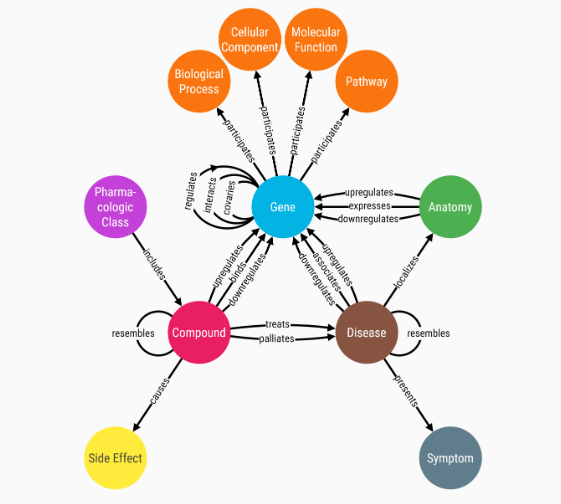







The project is based on Hetionet which is a heterogeneous biomedical knowledge graph. It encodes relationships uncovered by millions of studies conducted over the last half-century into a single resource.

I'm only using Disease, Gene and Compound meta nodes and the relationships between them.

The target is to predict new edges between Diseases and Genes (Disease-Gene associations)

and between those two node types (Disease, Gene) I'm only using the association edge type to make sure there is no information leak from other edge types

I used two different approaches for encoding the graph

building a normal homogeneous GNN and transform it with to_hetero function (basically makes a layer for every edge_type) like this tutorial
Used RGCN module which is based on this [paper](https://arxiv.org/abs/1703.06103)